# Problem Statement

Santander wants to find which customers will make a specific transaction in the future, irrespective of the amount of money transacted.

#### This kernels consists of : 

* Importing Data
* Reducing Memory Usage
* Missing Values
* Basic EDA
* Feature Correlation
* Baseliner
* Decision Tree
* Model Importances
* Bayesian Optimisation
* ELI5
* 5Fold Submission

In [121]:
#!pip install bayesian-optimization


In [122]:
import gc
import os
import time
import math
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedKFold

from sklearn.metrics import roc_auc_score
from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold

# Importing all models

# Classification
from sklearn.linear_model import LogisticRegression, ElasticNet, Lasso, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, \
    RandomForestClassifier, VotingClassifier
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, \
    RandomForestRegressor, VotingRegressor


#import lightgbm as lgb
#import xgboost as xgb
#import catboost as cat
#from catboost import Pool, CatBoostClassifier

import warnings
#print(os.listdir("../input"))
warnings.simplefilter('ignore')

In [123]:
total_start_time = time.time()

# Importing Data and Reducing Memory

In [124]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [125]:
#train = import_data("train_ver2.csv")
test = import_data("test_ver2.csv")
#sub = import_data("sample_submission.csv")

print("\n\nTest Size : \t{}".format(test.shape))


Memory usage of dataframe is 170.22 MB
Memory usage after optimization is: 58.01 MB
Decreased by 65.9%


Test Size : 	(929615, 24)


In [126]:
test.head(50)
#test

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,...,indext,conyuemp,canal_entrada,indfall,tipodom,cod_prov,nomprov,ind_actividad_cliente,renta,segmento
0,2016-06-28,15889,F,ES,V,56,1995-01-16,0,256,1,...,N,N,KAT,N,1,28.0,MADRID,1,326124.90,01 - TOP
1,2016-06-28,1170544,N,ES,H,36,2013-08-28,0,34,1,...,N,NaN,KAT,N,1,3.0,ALICANTE,0,NA,02 - PARTICULARES
2,2016-06-28,1170545,N,ES,V,22,2013-08-28,0,34,1,...,N,NaN,KHE,N,1,15.0,"CORUÑA, A",1,NA,03 - UNIVERSITARIO
3,2016-06-28,1170547,N,ES,H,22,2013-08-28,0,34,1,...,N,NaN,KHE,N,1,8.0,BARCELONA,0,148402.98,03 - UNIVERSITARIO
4,2016-06-28,1170548,N,ES,H,22,2013-08-28,0,34,1,...,N,NaN,KHE,N,1,7.0,"BALEARS, ILLES",0,106885.80,03 - UNIVERSITARIO
5,2016-06-28,1170550,N,ES,V,22,2013-08-28,0,34,1,...,N,NaN,KHE,N,1,8.0,BARCELONA,0,NA,03 - UNIVERSITARIO
6,2016-06-28,1170552,N,ES,H,51,2013-08-28,0,34,1,...,N,NaN,KFC,N,1,35.0,"PALMAS, LAS",1,96395.88,02 - PARTICULARES
7,2016-06-28,1170553,N,ES,H,22,2013-08-28,0,34,1,...,N,NaN,KHE,N,1,45.0,TOLEDO,0,NA,03 - UNIVERSITARIO
8,2016-06-28,1170555,N,ES,V,22,2013-08-28,0,34,1,...,N,NaN,KHE,N,1,28.0,MADRID,0,NA,03 - UNIVERSITARIO
9,2016-06-28,1170557,N,ES,H,22,2013-08-28,0,34,1,...,N,NaN,KHE,N,1,15.0,"CORUÑA, A",1,68322.72,03 - UNIVERSITARIO


In [127]:
#train.columns #PrinceG : 
#Train data has 24 columns to be used as features. Last 24 columsn represent the product to be recommended

In [128]:
test.columns #PrinceG : Test data has only the columns to be used as features

Index(['fecha_dato', 'ncodpers', 'ind_empleado', 'pais_residencia', 'sexo',
       'age', 'fecha_alta', 'ind_nuevo', 'antiguedad', 'indrel',
       'ult_fec_cli_1t', 'indrel_1mes', 'tiprel_1mes', 'indresi', 'indext',
       'conyuemp', 'canal_entrada', 'indfall', 'tipodom', 'cod_prov',
       'nomprov', 'ind_actividad_cliente', 'renta', 'segmento'],
      dtype='object')

In [129]:
test_features= pd.DataFrame(test,columns=['fecha_dato', 'ncodpers', 'ind_empleado', 'pais_residencia', 'sexo',
       'age', 'fecha_alta', 'ind_nuevo', 'antiguedad', 'indrel',
       'ult_fec_cli_1t', 'indrel_1mes', 'tiprel_1mes', 'indresi', 'indext',
       'conyuemp', 'canal_entrada', 'indfall', 'tipodom', 'cod_prov',
       'nomprov', 'ind_actividad_cliente', 'renta', 'segmento'])
test_features.columns

Index(['fecha_dato', 'ncodpers', 'ind_empleado', 'pais_residencia', 'sexo',
       'age', 'fecha_alta', 'ind_nuevo', 'antiguedad', 'indrel',
       'ult_fec_cli_1t', 'indrel_1mes', 'tiprel_1mes', 'indresi', 'indext',
       'conyuemp', 'canal_entrada', 'indfall', 'tipodom', 'cod_prov',
       'nomprov', 'ind_actividad_cliente', 'renta', 'segmento'],
      dtype='object')

In [130]:
def missing_values(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: 'Missing Values', 1: '% of Total Values'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
                                                              "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

#miss_train = missing_values(train)
#miss_test = missing_values(test)

In [131]:
#miss_train #PrinceG : View the missing data
##PrinceG: conyuemp and ult_fec_cli_1t columns can be dropped as more than 99% values are missing

In [132]:
#miss_test
#PrinceG: conyuemp and ult_fec_cli_1t columns can be dropped as more than 99% values are missing

In [133]:
traintesting = pd.DataFrame(test.values,columns=['date', 'customer_code', 'emp_status', 'residence_code', 'sex', 'age', 'date_first_prod', 'new_customer', 'seniority_inmonths',
'prime_customer', 'prime_lastdate', 'customer_type', 'customer_relation', 'is_residence', 'is_foreigner', 'spouse', 'channel',
'deceased', 'primary_address', 'province_code', 'province_name', 'status_ai', 'gincome', 'social_segment'])

start_time = time.time()
reduce_mem_usage(traintesting)
print('Done. Time elapsed: {:.2f}s'.format(time.time() - start_time))

In [134]:
traintesting.drop(columns=['province_name'],axis=1,inplace=True) #Province Code shall be used instead


In [135]:
## verify which all columns have Null / NaN values
traintesting.isnull().sum()

date                       0
customer_code              0
emp_status                 0
residence_code             0
sex                        5
age                        0
date_first_prod            0
new_customer               0
seniority_inmonths         0
prime_customer             0
prime_lastdate        927932
customer_type             23
customer_relation         23
is_residence               0
is_foreigner               0
spouse                929511
channel                 2081
deceased                   0
primary_address            0
province_code           3996
status_ai                  0
gincome                    0
social_segment          2248
dtype: int64

In [136]:
traintesting['date'] = traintesting['date'].replace('-','',regex=True).str.strip(' ,')

In [137]:
traintesting['date_first_prod'] = traintesting['date_first_prod'].astype(str).replace('-','',regex=True).str.strip(' ,')
traintesting['prime_lastdate'] = traintesting['prime_lastdate'].astype(str).replace('-','',regex=True).str.strip(' ,')

In [138]:
traintesting['date_first_prod']

0         19950116
1         20130828
2         20130828
3         20130828
4         20130828
            ...   
929610    19990421
929611    20061129
929612    20061129
929613    20061129
929614    20061129
Name: date_first_prod, Length: 929615, dtype: object

In [139]:
## Load Dictionaries
Channel_dict = np.load('Channel.npy',allow_pickle='TRUE').item()
Residence_Code= np.load('Residence_Code.npy',allow_pickle='TRUE').item()
ProdRecommed_dict= np.load('ProdRecommed.npy',allow_pickle='TRUE').item()
Channel_dict[0]

{0: 0.0,
 1: 1.0,
 2: 2.0,
 3: 3.0,
 4: 4.0,
 5: 5.0,
 6: 7.0,
 7: 8.0,
 8: 9.0,
 9: 10.0,
 10: 11.0,
 11: 12.0,
 12: 13.0,
 13: 14.0,
 14: 15.0,
 15: 16.0,
 16: 17.0,
 17: 18.0,
 18: 19.0,
 19: 20.0,
 20: 21.0,
 21: 22.0,
 22: 23.0,
 23: 24.0,
 24: 25.0,
 25: 26.0,
 26: 27.0,
 27: 28.0,
 28: 29.0,
 29: 30.0,
 30: 31.0,
 31: 32.0,
 32: 33.0,
 33: 34.0,
 34: 35.0,
 35: 36.0,
 36: 37.0,
 37: 38.0,
 38: 39.0,
 39: 40.0,
 40: 41.0,
 41: 42.0,
 42: 43.0,
 43: 44.0,
 44: 45.0,
 45: 46.0,
 46: 47.0,
 47: 48.0,
 48: 49.0,
 49: 50.0,
 50: 51.0,
 51: 52.0,
 52: 53.0,
 53: 54.0,
 54: 55.0,
 55: 56.0,
 56: 57.0,
 57: 58.0,
 58: 59.0,
 59: 60.0,
 60: 61.0,
 61: 62.0,
 62: 63.0,
 63: 64.0,
 64: 65.0,
 65: 66.0,
 66: 67.0,
 67: 68.0,
 68: 69.0,
 69: 70.0,
 70: 71.0,
 71: 72.0,
 72: 73.0,
 73: 74.0,
 74: 75.0,
 75: 76.0,
 76: 77.0,
 77: 78.0,
 78: 79.0,
 79: 80.0,
 80: 81.0,
 81: 82.0,
 82: 83.0,
 83: 84.0,
 84: 85.0,
 85: 86.0,
 86: 87.0,
 87: 88.0,
 88: 89.0,
 89: 90.0,
 90: 91.0,
 91: 92.0,
 92: 93

In [140]:
Residence_Code[0]

{0: 'KHL',
 1: 'KHE',
 2: 'KHD',
 3: 'KFA',
 4: 'KFC',
 5: 'KAT',
 6: nan,
 7: 'KAZ',
 8: 'RED',
 9: 'KHC',
 10: 'KHK',
 11: 'KGN',
 12: 'KHM',
 13: 'KHO',
 14: 'KDH',
 15: 'KEH',
 16: 'KAD',
 17: 'KBG',
 18: 'KGC',
 19: 'KHF',
 20: 'KFK',
 21: 'KHN',
 22: 'KHA',
 23: 'KAF',
 24: 'KGX',
 25: 'KFD',
 26: 'KAG',
 27: 'KFG',
 28: 'KAB',
 29: 'KCC',
 30: 'KAE',
 31: 'KAH',
 32: 'KAR',
 33: 'KFJ',
 34: 'KFL',
 35: 'KAI',
 36: 'KFU',
 37: 'KAQ',
 38: 'KFS',
 39: 'KAA',
 40: 'KFP',
 41: 'KAJ',
 42: 'KFN',
 43: 'KGV',
 44: 'KGY',
 45: 'KFF',
 46: 'KAP',
 47: 'KDE',
 48: 'KFV',
 49: '013',
 50: 'K00',
 51: 'KAK',
 52: 'KCK',
 53: 'KCL',
 54: 'KAY',
 55: 'KBU',
 56: 'KDR',
 57: 'KAC',
 58: 'KDT',
 59: 'KCG',
 60: 'KDO',
 61: 'KDY',
 62: 'KBQ',
 63: 'KDA',
 64: 'KBO',
 65: 'KCI',
 66: 'KEC',
 67: 'KBZ',
 68: 'KES',
 69: 'KDX',
 70: 'KAS',
 71: '007',
 72: 'KEU',
 73: 'KCA',
 74: 'KAL',
 75: 'KDC',
 76: 'KAW',
 77: 'KCS',
 78: 'KCB',
 79: 'KDU',
 80: 'KDQ',
 81: 'KCN',
 82: 'KCM',
 83: '004',
 84:

In [141]:
ProdRecommed_dict[0]

{0: 'Current Accounts',
 1: 'Short-term deposits',
 2: 'Current Accounts, Direct Debit',
 3: 'Current Accounts, e-account',
 4: '',
 5: 'Current Accounts, e-account, Direct Debit',
 6: 'Current Accounts, e-account, Securities',
 7: 'Payroll Account, e-account, Direct Debit',
 8: 'e-account',
 9: 'Payroll Account, e-account, Taxes, Direct Debit',
 10: 'Payroll Account, e-account, Securities, Direct Debit',
 11: 'Payroll Account, e-account, Taxes, Credit Card, Payroll, Direct Debit',
 12: 'Direct Debit',
 13: 'Payroll Account, Payroll, Direct Debit',
 14: 'Payroll Account, Payroll',
 15: 'Payroll Account',
 16: 'Payroll Account, e-account, Payroll, Direct Debit',
 17: 'e-account, Credit Card, Direct Debit',
 18: 'Payroll Account, e-account, Payroll',
 19: 'Current Accounts, Taxes, Direct Debit',
 20: 'Current Accounts, Más particular Account',
 21: 'Junior Account',
 22: 'Payroll Account, e-account',
 23: 'Current Accounts, Long-term deposits, e-account',
 24: 'Payroll Account, e-account

In [142]:
traintesting['residence_code']

0         ES
1         ES
2         ES
3         ES
4         ES
          ..
929610    ES
929611    ES
929612    ES
929613    ES
929614    ES
Name: residence_code, Length: 929615, dtype: object

In [143]:
new_dict_res_code = dict([(value, key) for key, value in Residence_Code[0].items()]) 
#new_dict_res_code
#traintesting['residence_code'].astype(str)
traintesting['residence_code'] = traintesting['residence_code'].map(Residence_Code[0])
#traintesting['residence_code']
#new_dict_res_code
#traintesting['residence_code'].unique()

In [144]:
traintesting['residence_code'].tail()

929610    NaN
929611    NaN
929612    NaN
929613    NaN
929614    NaN
Name: residence_code, dtype: object

In [168]:
new_dict_res_code1 = dict([(value, key) for key, value in Channel_dict[0].items()]) 
traintesting['channel'].astype(str)
traintesting['channel'] = traintesting['channel'].map(new_dict_res_code1)
traintesting['channel']
#new_dict_res_code
#traintesting['residence_code'].unique()

0         1
1         1
2         1
3         1
4         1
         ..
929610    1
929611    1
929612    1
929613    1
929614    1
Name: channel, Length: 929615, dtype: int64

In [169]:
new_dict_res_code

{'KHL': 0,
 'KHE': 1,
 'KHD': 2,
 'KFA': 3,
 'KFC': 4,
 'KAT': 5,
 nan: 6,
 'KAZ': 7,
 'RED': 8,
 'KHC': 9,
 'KHK': 10,
 'KGN': 11,
 'KHM': 12,
 'KHO': 13,
 'KDH': 14,
 'KEH': 15,
 'KAD': 16,
 'KBG': 17,
 'KGC': 18,
 'KHF': 19,
 'KFK': 20,
 'KHN': 21,
 'KHA': 22,
 'KAF': 23,
 'KGX': 24,
 'KFD': 25,
 'KAG': 26,
 'KFG': 27,
 'KAB': 28,
 'KCC': 29,
 'KAE': 30,
 'KAH': 31,
 'KAR': 32,
 'KFJ': 33,
 'KFL': 34,
 'KAI': 35,
 'KFU': 36,
 'KAQ': 37,
 'KFS': 38,
 'KAA': 39,
 'KFP': 40,
 'KAJ': 41,
 'KFN': 42,
 'KGV': 43,
 'KGY': 44,
 'KFF': 45,
 'KAP': 46,
 'KDE': 47,
 'KFV': 48,
 '013': 49,
 'K00': 50,
 'KAK': 51,
 'KCK': 52,
 'KCL': 53,
 'KAY': 54,
 'KBU': 55,
 'KDR': 56,
 'KAC': 57,
 'KDT': 58,
 'KCG': 59,
 'KDO': 60,
 'KDY': 61,
 'KBQ': 62,
 'KDA': 63,
 'KBO': 64,
 'KCI': 65,
 'KEC': 66,
 'KBZ': 67,
 'KES': 68,
 'KDX': 69,
 'KAS': 70,
 '007': 71,
 'KEU': 72,
 'KCA': 73,
 'KAL': 74,
 'KDC': 75,
 'KAW': 76,
 'KCS': 77,
 'KCB': 78,
 'KDU': 79,
 'KDQ': 80,
 'KCN': 81,
 'KCM': 82,
 '004': 83,
 'KC

In [147]:
def plot_corr(data):
    data_correlation = data.corr()
    f, ax = plt.subplots(figsize=(100, 100))
    sns.heatmap(data_correlation,
                xticklabels=data_correlation.columns.values,
                yticklabels=data_correlation.columns.values, annot=True)
    plt.show()

In [170]:
##Mapping the columns to be used for algorithm to process
traintesting['customer_type'] = traintesting['customer_type'].map({'1.0':1, '1':1, '2.0':2, '2':2, '3.0':3, '3':3, '4.0':4, '4':4, 'P':'5'})
traintesting['emp_status'] = traintesting['emp_status'].map({'N':1, 'A':2, 'B':3, 'F':4, 'S':5})
traintesting['sex'] = traintesting['sex'].map({'V':'1', 'H':'2'})
traintesting['deceased'] = traintesting['deceased'].map({'N':'0', 'S':'1'})
traintesting['is_foreigner'] = traintesting['is_foreigner'].map({'N':'1', 'S':'2'})
traintesting['is_residence'] = traintesting['is_residence'].map({'N':'1', 'S':'2'})
traintesting['spouse'] = traintesting['spouse'].map({'N':'1', 'S':'2'})
traintesting['social_segment'] = traintesting['social_segment'].map({'01 - TOP':'1', '02 - PARTICULARE':'2', '03 - UNIVERSITARIO':'3'})
traintesting['customer_relation'] = traintesting['social_segment'].map({'A':'1', 'I':'2', 'P':'3', 'R':'4', 'N':'5'})
#traintesting.replace(' NA',"0",inplace=True)

In [171]:
traintesting.replace(' NA',"NaN",inplace=True)
traintesting.replace('     NA',"NaN",inplace=True)
traintesting.replace('         NA',"NaN",inplace=True)
#traintesting.replace('',"0",inplace=True)

In [172]:
#traintesting.dropna(axis=1)
traintesting['spouse'].replace('NaN','2',inplace=True)
traintesting['spouse'].unique()
traintesting['spouse'].fillna('2',inplace=True)


In [173]:
traintesting['social_segment'].fillna('3',inplace=True)
#traintesting['gincome'].fillna('68322.72',inplace=True)#Gross Income is considered for Mean of incomes. This may be wrong assumption
traintesting['age'].fillna(traintesting['age'].mean(),inplace=True)#Gross Income is considered for Mean of Age
traintesting['emp_status'].fillna('1',inplace=True)
traintesting['residence_code'].fillna('1',inplace=True)
traintesting['deceased'].fillna('0',inplace=True)
traintesting['new_customer'].fillna('0.0',inplace=True)
traintesting['status_ai'].fillna('0.0',inplace=True)
traintesting['channel'].fillna('1',inplace=True)
traintesting['prime_customer'].fillna('1.0',inplace=True)
traintesting['customer_type'].fillna('1',inplace=True)
traintesting['sex'].fillna('1',inplace=True)
traintesting['is_residence'].fillna('1',inplace=True) #Replace NaN with value 1 means he is not a resident
traintesting['is_foreigner'].fillna('1',inplace=True) #Replace NaN with value 1 means he is not a foreigner
traintesting['customer_relation'].fillna('0',inplace=True)
traintesting['primary_address'].fillna('0',inplace=True)#Replace NaN with 0 as customer has not given Primary address
traintesting['province_code'].fillna('0.0',inplace=True)#Replace NaN with 0.0 , the value not existing in Province Code list
#traintesting['province_name'].fillna('NotPROVIDED',inplace=True)#Replace NaN with NotPROVIDED , the value not existing in Province Name list
traintesting['date_first_prod'].fillna('0',inplace=True)#Replace NaN with 0 , to identfy that date not existing, in such cases the product offering may differ
traintesting['prime_lastdate'].fillna('0',inplace=True)#Replace NaN with 0 , to identfy that date not existing, in such cases the product offering may differ



In [174]:
#traintesting['gincome'].mean()

In [175]:
traintesting['age'].value_counts()

24.0     50706
23.0     49604
22.0     47674
21.0     46322
25.0     41429
         ...  
114.0        6
117.0        1
118.0        1
164.0        1
127.0        1
Name: age, Length: 118, dtype: int64

In [176]:
traintesting['age'].fillna('25',inplace=True)#May be a wromg assumption from Business prespective
traintesting['age'].replace('NaN','25',inplace=True)#May be a wromg assumption from Business prespective

In [177]:
traintesting['seniority_inmonths'].fillna('100',inplace=True)#May be a wromg assumption from Business prespective
traintesting['seniority_inmonths'].replace('NaN','100',inplace=True)#May be a wromg assumption from Business prespective
traintesting['seniority_inmonths'].unique()

array([ 2.56000e+02,  3.40000e+01,  1.10000e+01,  5.00000e+00,
        3.30000e+01,  4.00000e+00,  3.00000e+01,  3.20000e+01,
        1.50000e+01,  1.80000e+01,  2.50000e+01,  2.30000e+01,
        1.60000e+01,  2.60000e+01,  3.10000e+01,  1.30000e+01,
        2.70000e+01,  2.90000e+01,  2.00000e+01,  8.00000e+00,
        7.00000e+00,  2.40000e+01,  1.40000e+01,  3.00000e+00,
        1.00000e+00,  1.00000e+01,  2.80000e+01,  2.20000e+01,
        2.10000e+01,  2.00000e+00,  1.90000e+01,  1.70000e+01,
        1.20000e+01,  9.00000e+00,  6.00000e+00,  3.70000e+01,
        3.50000e+01,  3.60000e+01,  3.80000e+01,  1.50000e+02,
        4.10000e+01,  4.00000e+01,  3.90000e+01,  0.00000e+00,
        4.70000e+01,  4.80000e+01,  4.50000e+01,  4.20000e+01,
        4.40000e+01,  4.60000e+01,  4.90000e+01,  4.30000e+01,
        5.10000e+01,  5.00000e+01,  5.20000e+01,  5.50000e+01,
        5.40000e+01,  5.30000e+01,  5.60000e+01,  1.86000e+02,
        1.68000e+02,  1.28000e+02,  1.20000e+02,  2.200

In [178]:
traintesting['sex'].unique()

array(['1'], dtype=object)

In [179]:
traintesting['age'].unique()

array([ 56.,  36.,  22.,  51.,  41.,  33.,  23.,  43.,  63.,  62.,  32.,
        58.,  71.,  31.,  30.,  59.,  45.,  37.,  39.,  38.,  46.,  34.,
        35.,  42.,  29.,  88.,  64.,  48.,  72.,  47.,  27.,  24.,  50.,
        49.,  57.,  67.,  25.,  28.,  13.,  40.,  53.,  54.,  26.,  11.,
        21.,  60.,  44.,  55.,   7.,  52.,  66.,  90.,  73.,  78.,  79.,
        61.,  69.,  12.,   9.,  65.,  77.,  83.,  81.,  10.,   5.,  18.,
        17.,  87.,  70.,  80.,  75.,  68.,  74.,  16.,   4.,  82.,  91.,
        76.,  19.,  15.,   6.,  97.,  89.,  85.,  86.,  14.,  20.,   8.,
        84.,  95.,  93., 100.,  96.,  92.,  98.,  94., 105., 102., 101.,
       104., 103.,  99.,   3.,   2., 116., 106., 107., 109., 110., 117.,
       108., 113., 111., 112., 114., 164., 118., 127.])

In [180]:
traintesting['social_segment'].value_counts()

3    929615
Name: social_segment, dtype: int64

In [181]:
traintesting['gincome'].value_counts()

68322.72     227968
451931.22       354
463625.16       111
181042.20        91
128318.52        91
              ...  
70794.84          1
127488.57         1
220004.16         1
574080.63         1
159395.52         1
Name: gincome, Length: 516402, dtype: int64

In [182]:
traintesting['gincome'] = traintesting['gincome'].astype(np.float64)
traintesting['gincome'].unique()


array([326124.9 ,  68322.72, 148402.98, ..., 139164.12, 100647.45,
        72765.27])

In [183]:
traintesting['gincome'].fillna('68322.72',inplace=True)
traintesting['prime_lastdate'].fillna('0',inplace=True)

In [184]:
## verify which all columns have Null / NaN values
traintesting.isnull().sum()

date                  0
customer_code         0
emp_status            0
residence_code        0
sex                   0
age                   0
date_first_prod       0
new_customer          0
seniority_inmonths    0
prime_customer        0
prime_lastdate        0
customer_type         0
customer_relation     0
is_residence          0
is_foreigner          0
spouse                0
channel               0
deceased              0
primary_address       0
province_code         0
status_ai             0
gincome               0
social_segment        0
dtype: int64

In [185]:
## Find which all rown and column has NaN
col_mask=traintesting.isnull().any(axis=0) 
row_mask=traintesting.isnull().any(axis=1)
traintesting.loc[row_mask,col_mask]

""


In [186]:
traintesting=traintesting.astype(np.float64)

In [187]:
traintesting.corr()


,date,customer_code,emp_status,residence_code,sex,age,date_first_prod,new_customer,seniority_inmonths,prime_customer,...,is_residence,is_foreigner,spouse,channel,deceased,primary_address,province_code,status_ai,gincome,social_segment
date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
customer_code,NaN,1.000000,NaN,NaN,NaN,-0.603296,0.973921,0.222253,-0.033687,0.030565,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.029975,-0.104326,-0.101014,NaN
emp_status,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
residence_code,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sex,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,NaN,-0.603296,NaN,NaN,NaN,1.000000,-0.594524,-0.005839,0.020926,0.002663,...,NaN,NaN,NaN,NaN,NaN,NaN,0.043464,0.121830,0.070784,NaN
date_first_prod,NaN,0.973921,NaN,NaN,NaN,-0.594524,1.000000,0.192618,-0.035339,0.026256,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.032988,-0.104607,-0.097530,NaN
new_customer,NaN,0.222253,NaN,NaN,NaN,-0.005839,0.192618,1.000000,-0.007008,0.070302,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.002310,0.078882,-0.040470,NaN
seniority_inmonths,NaN,-0.033687,NaN,NaN,NaN,0.020926,-0.035339,-0.007008,1.000000,-0.000960,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000957,0.003080,0.003352,NaN
prime_customer,NaN,0.030565,NaN,NaN,NaN,0.002663,0.026256,0.070302,-0.000960,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.001069,-0.030492,-0.004982,NaN


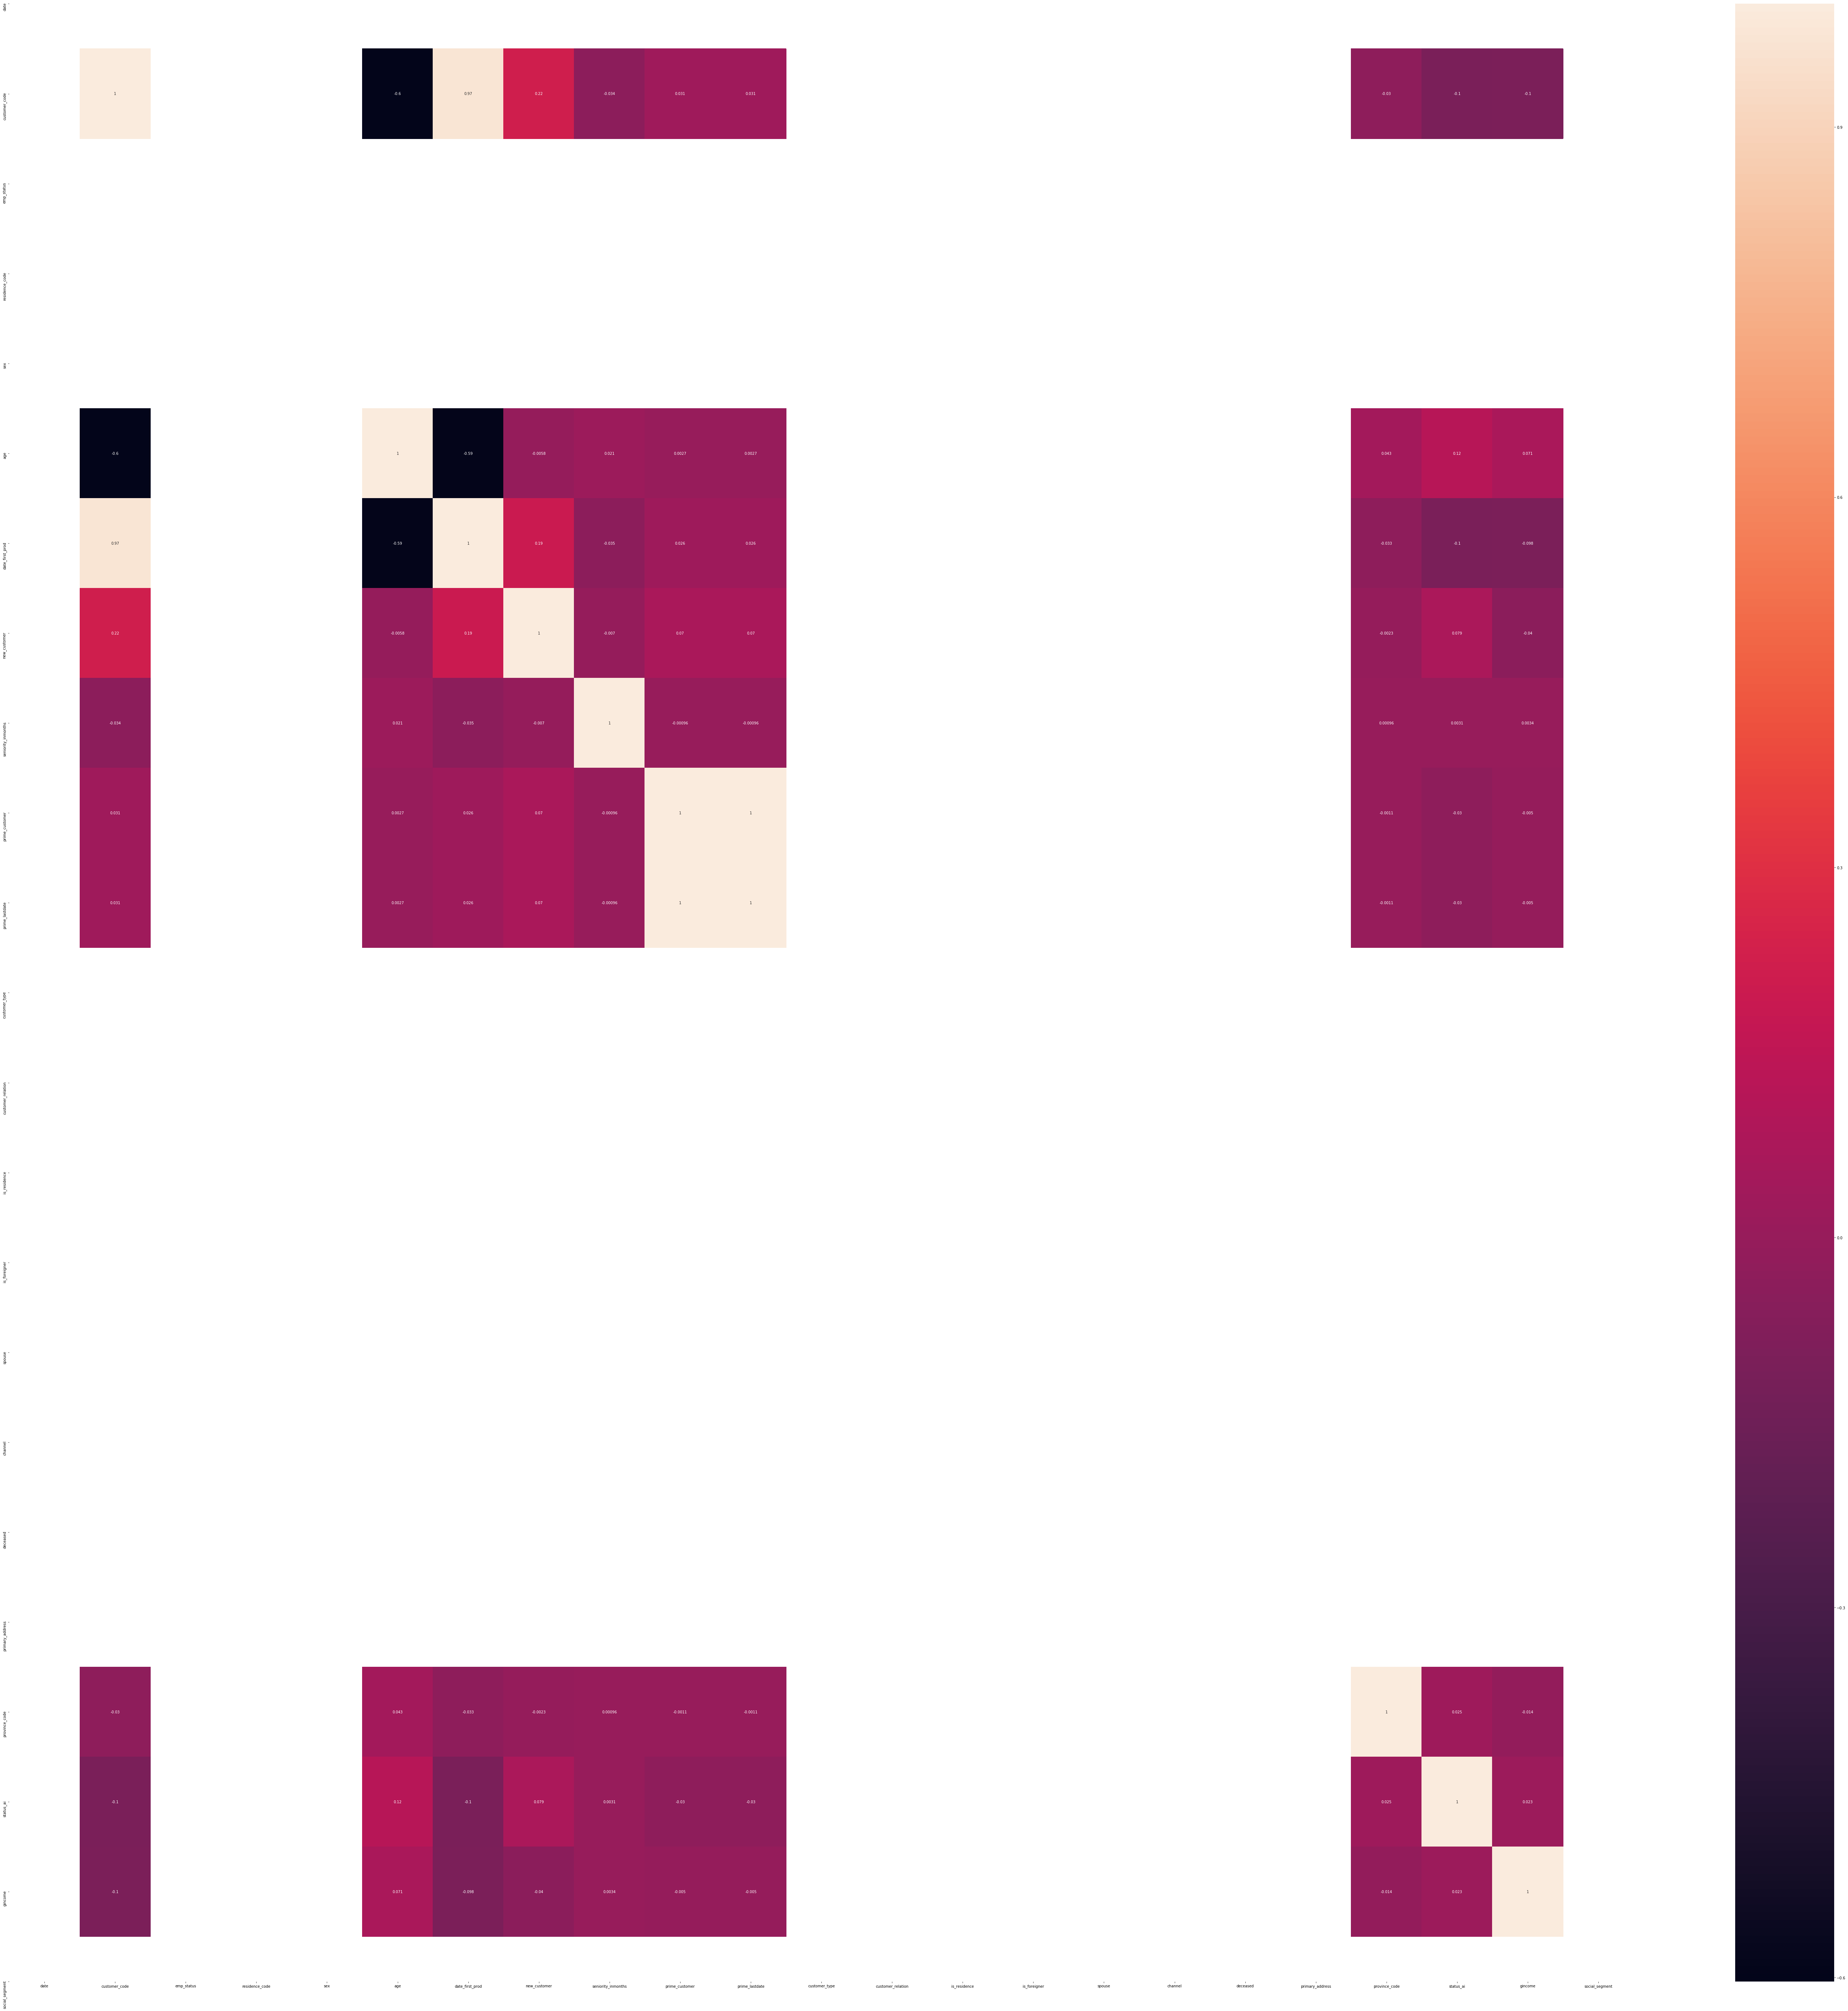

In [188]:
plot_corr(traintesting)

In [189]:
import pickle
filename = 'dtr.sav'
#pickle.dump(reg, open(filename, 'wb'))
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(x_test,y_test)
y_predict= loaded_model.predict(traintesting)
print(y_predict)

[0. 0. 0. ... 0. 4. 4.]


In [190]:

traintesting['ProdRecommedPredict'] = y_predict
traintesting['ProdRecommedPredict'].astype('str')
#ProdRecommed_dict[0].astype('str')
traintesting['ProdRecommedPredict'] = traintesting['ProdRecommedPredict'].map(ProdRecommed_dict[0])

In [194]:
traintesting

,date,customer_code,emp_status,residence_code,sex,age,date_first_prod,new_customer,seniority_inmonths,prime_customer,...,is_foreigner,spouse,channel,deceased,primary_address,province_code,status_ai,gincome,social_segment,ProdRecommedPredict
0,20160628.0,15889.0,1.0,1.0,1.0,56.0,19950116.0,0.0,256.0,1.0,...,1.0,2.0,1.0,0.0,1.0,28.0,1.0,326124.90,3.0,Current Accounts
1,20160628.0,1170544.0,1.0,1.0,1.0,36.0,20130828.0,0.0,34.0,1.0,...,1.0,2.0,1.0,0.0,1.0,3.0,0.0,68322.72,3.0,Current Accounts
2,20160628.0,1170545.0,1.0,1.0,1.0,22.0,20130828.0,0.0,34.0,1.0,...,1.0,2.0,1.0,0.0,1.0,15.0,1.0,68322.72,3.0,Current Accounts
3,20160628.0,1170547.0,1.0,1.0,1.0,22.0,20130828.0,0.0,34.0,1.0,...,1.0,2.0,1.0,0.0,1.0,8.0,0.0,148402.98,3.0,Current Accounts
4,20160628.0,1170548.0,1.0,1.0,1.0,22.0,20130828.0,0.0,34.0,1.0,...,1.0,2.0,1.0,0.0,1.0,7.0,0.0,106885.80,3.0,Current Accounts
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
929610,20160628.0,660237.0,1.0,1.0,1.0,55.0,19990421.0,0.0,206.0,1.0,...,1.0,2.0,1.0,0.0,1.0,28.0,1.0,128643.57,3.0,"Current Accounts, Payroll Account, e-account, ..."
929611,20160628.0,660238.0,1.0,1.0,1.0,30.0,20061129.0,0.0,115.0,1.0,...,1.0,2.0,1.0,0.0,1.0,26.0,0.0,68322.72,3.0,
929612,20160628.0,660240.0,1.0,1.0,1.0,52.0,20061129.0,0.0,115.0,1.0,...,1.0,2.0,1.0,0.0,1.0,33.0,1.0,72765.27,3.0,Current Accounts
929613,20160628.0,660243.0,1.0,1.0,1.0,32.0,20061129.0,0.0,115.0,1.0,...,1.0,2.0,1.0,0.0,1.0,33.0,0.0,147488.88,3.0,


In [195]:
traintesting.to_csv('traintesting_Results.csv')

In [192]:
print('Done. Time elapsed: {:.2f}s'.format(time.time() - total_start_time))

Done. Time elapsed: 175.22s


# Bayesian Optimisation

start_time = time.time()
bayesian_tr_index, bayesian_val_index  = list(StratifiedKFold(n_splits=2, shuffle=True, random_state=1).split(traintesting, traintesting.ProductRecommed.values))[0]
print(len(bayesian_tr_index), len(bayesian_val_index))
print('Done. Time elapsed: {:.2f}s'.format(time.time() - start_time))

# Function for LGB model creation for bayesian optimisation
start_time = time.time()
def LGB_bayesian(
    num_leaves,  # int
    min_data_in_leaf,  # int
    learning_rate,
    min_sum_hessian_in_leaf,    # int  
    feature_fraction,
    lambda_l1,
    lambda_l2,
    min_gain_to_split,
    max_depth):
    
    # LightGBM expects next three parameters need to be integer. So we make them integer
    num_leaves = int(num_leaves)
    min_data_in_leaf = int(min_data_in_leaf)
    max_depth = int(max_depth)

    assert type(num_leaves) == int
    assert type(min_data_in_leaf) == int
    assert type(max_depth) == int

    param = {
        'num_leaves': num_leaves,
        'max_bin': 63,
        'min_data_in_leaf': min_data_in_leaf,
        'learning_rate': learning_rate,
        'min_sum_hessian_in_leaf': min_sum_hessian_in_leaf,
        'bagging_fraction': 1.0,
        'bagging_freq': 5,
        'feature_fraction': feature_fraction,
        'lambda_l1': lambda_l1,
        'lambda_l2': lambda_l2,
        'min_gain_to_split': min_gain_to_split,
        'max_depth': max_depth,
        'save_binary': True, 
        'seed': 13,
        'feature_fraction_seed': 13,
        'bagging_seed': 13,
        'drop_seed': 13,
        'data_random_seed': 13,
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'verbose': 1,
        'metric': 'auc',
        'is_unbalance': True,
        'boost_from_average': False,   

    }    
    
    
    xg_train = lgb.Dataset(traintesting.iloc[bayesian_tr_index][traintesting.drop(["ProductRecommed"], axis=1)].values,
                           label=traintesting.iloc[bayesian_tr_index][traintesting['ProductRecommed']].values,
                           feature_name=traintesting.drop(["ProductRecommed"], axis=1),
                           free_raw_data = False
                           )
    xg_valid = lgb.Dataset(traintesting.iloc[bayesian_val_index][traintesting.drop(["ProductRecommed"], axis=1)].values,
                           label=traintesting.iloc[bayesian_val_index][traintesting['ProductRecommed']].values,
                           feature_name=traintesting.drop(["ProductRecommed"], axis=1),
                           free_raw_data = False
                           )   

    num_round = 5000
    clf = lgb.traintesting(param, xg_train, num_round, valid_sets = [xg_valid], verbose_eval=250, early_stopping_rounds = 50)
    
    predictions = clf.predict(traintesting.iloc[bayesian_val_index][traintesting.drop(["ProductRecommed"], axis=1)].values, num_iteration=clf.best_iteration)   
    
    score = roc_auc_score(train.iloc[bayesian_val_index][traintesting['ProductRecommed']].values, predictions)
    
    return score

# Region Space for Bayesian Optimisation
region_space_LGB = {
    'num_leaves': (5, 20), 
    'min_data_in_leaf': (5, 20),  
    'learning_rate': (0.01, 0.3),
    'min_sum_hessian_in_leaf': (0.00001, 0.01),    
    'feature_fraction': (0.05, 0.5),
    'lambda_l1': (0, 5.0), 
    'lambda_l2': (0, 5.0), 
    'min_gain_to_split': (0, 1.0),
    'max_depth':(3,15),
}

LGB_BO = BayesianOptimization(LGB_bayesian, region_space_LGB, random_state=13)
print('Done. Time elapsed: {:.2f}s'.format(time.time() - start_time))

LGB_BO.maximize(init_points=init_points)

start_time = time.time()
init_points = 5
n_iter = 5

LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)
print('Done. Time elapsed: {:.2f}s'.format(time.time() - start_time))

LGB_BO.max['ProductRecommed']

LGB_BO.max['params']

param_lgb = {
        'num_leaves': int(LGB_BO.max['params']['num_leaves']),
        'max_bin': 63,
        'min_data_in_leaf': int(LGB_BO.max['params']['min_data_in_leaf']),
        'learning_rate': LGB_BO.max['params']['learning_rate'],
        'min_sum_hessian_in_leaf': LGB_BO.max['params']['min_sum_hessian_in_leaf'],
        'bagging_fraction': 1.0, 
        'bagging_freq': 5, 
        'feature_fraction': LGB_BO.max['params']['feature_fraction'],
        'lambda_l1': LGB_BO.max['params']['lambda_l1'],
        'lambda_l2': LGB_BO.max['params']['lambda_l2'],
        'min_gain_to_split': LGB_BO.max['params']['min_gain_to_split'],
        'max_depth': int(LGB_BO.max['params']['max_depth']),
        'save_binary': True,
        'seed': 13,
        'feature_fraction_seed': 13,
        'bagging_seed': 13,
        'drop_seed': 13,
        'data_random_seed': 13,
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'verbose': 1,
        'metric': 'auc',
        'is_unbalance': True,
        'boost_from_average': False,
    }

# Model Interpreting
### ELI5

import eli5

model = lgb.LGBMClassifier(**param_lgb, n_estimators = 20000, n_jobs = -1)
X_train, X_valid, y_train, y_valid = train_test_split(train[features], train[target], test_size=0.2, stratify=train[target])
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=200)

eli5.show_weights(model, targets=[0, 1], feature_names=list(X_train.columns), top=40, feature_filter=lambda x: x != '<BIAS>')

#### Taking top 100 features and checking if the scores improves.

top_features = [i for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i][:100]
X1 = train[top_features]
X_train, X_valid, y_train, y_valid = train_test_split(X1, train[target], test_size=0.2, stratify=train[target])
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=200)

* Without removal score : 0.89538
* With removal score : 0.883403

**So ELI5 isn't helping in reducing the features.**

# 5Fold Prediction & Submission

%%time
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

y_pred_lgb = np.zeros(len(test))
num_round = 20000
for fold_n, (train_index, valid_index) in enumerate(folds.split(train[features], train[target])):
    print('Fold', fold_n, 'started at', time.ctime())
    X_train, X_valid = train[features].iloc[train_index], train[features].iloc[valid_index]
    y_train, y_valid = train[target].iloc[train_index], train[target].iloc[valid_index]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)
        
    lgb_model = lgb.train(
        param_lgb,
        train_data,num_round,
        valid_sets = [train_data, valid_data],
        verbose_eval=1000,
        early_stopping_rounds = 1000)
            
    y_pred_lgb += lgb_model.predict(test[features], num_iteration=lgb_model.best_iteration)/5

# Submitting the 5Fold LGB Predictions
submission_lgb = pd.DataFrame({
        "ID_code": test["ID_code"],
        "target": y_pred_lgb
    })
submission_lgb.to_csv('sub_lgb.csv', index=False)

# This submission score 0.90038 on public leaderboard. (Almost top 9% in Public LB)

# Conclusion

TODO - 
1. H20 AutoML
1. Using XGBoost, Catboost
1. Ensembling, Stacking, Blending
1. Feature Removal